In [3]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/30175
# 标题：A股最强板块动量趋势（最终版）

from __future__ import print_function, division
import pandas as pd
from pprint import pprint

from jqdata import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

# 获取行业列表

# 申万一级，若想使用此行业，请将下面两行代码最左边的 # 及空格删掉，此行不要改动。
# print("使用申万一级行业")
# industry_level = "sw_l1"

# 申万二级，若想使用此行业，请将下面两行代码最左边的 # 及空格删掉，此行不要改动。
# print("使用申万二级行业")
# industry_level = "sw_l2"

# 申万三级，若想使用此行业，请将下面两行代码最左边的 # 及空格删掉，此行不要改动。
print("使用申万三级行业")
industry_level = "sw_l3"

# 聚宽一级，若想使用此行业，请将下面两行代码最左边的 # 及空格删掉，此行不要改动。
# print("使用聚宽一级行业")
# industry_level = "jq_l1"

# 聚宽二级，若想使用此行业，请将下面两行代码最左边的 # 及空格删掉，此行不要改动。
# print("使用聚宽二级行业")
# industry_level = "jq_l2"

# 证监会，若想使用此行业，请将下面两行代码最左边的 # 及空格删掉，此行不要改动。
# print("使用证监会行业")
# industry_level = "zjw"

today = datetime.datetime.today().strftime("%Y-%m-%d")

# 获取所有个股
all_securities_pd = get_all_securities()

# 过滤掉退市股
filtered_securities_pd = all_securities_pd[all_securities_pd.end_date>datetime.date.today()]

# 过滤掉最近 150 天上市的新股
last_150_days = datetime.date.today() - datetime.timedelta(days=150)
filtered_securities_pd = filtered_securities_pd[filtered_securities_pd.start_date<last_150_days]

# 过滤掉 st 股
security_is_st_pd = get_extras('is_st', filtered_securities_pd.index.tolist(), end_date=today, count=1).T
security_is_st_pd.columns=['is_st'] 
filtered_securities_pd = filtered_securities_pd.join(security_is_st_pd)
filtered_securities_pd = filtered_securities_pd[filtered_securities_pd.is_st==False]

security_code_list = filtered_securities_pd.index.tolist()

# 获取个股编码与个股名称对应关系
security_code_name_dict = {}
for row in filtered_securities_pd.itertuples():
    security_code = row.Index
    security_name = row.display_name
    security_code_name_dict[security_code] = security_name

security_industry_dict = {}
industry_code_name_dict = {}
industry_code_security_count_dict = {}
for security_code, industry_info_dict in get_industry(security_code_list).items():
    
    industry_info = industry_info_dict.get(industry_level)
    if not industry_info:
        security_code_list.remove(security_code)
        print("没有获取到{}({})对应的行业信息".format(security_code, security_code_name_dict[security_code]))
        continue
        
    industry_code = industry_info.get('industry_code')
    if not industry_code:
        security_code_list.remove(security_code)
        print("没有获取到{}({})对应的行业编码".format(security_code, security_code_name_dict[security_code]))
        continue
        
    # 获取个股编码与行业编码对应关系
    security_industry_dict[security_code] = industry_code 
    
    # 获取行业内个股总数
    if industry_code not in industry_code_security_count_dict:
        industry_code_security_count_dict[industry_code] = 1
    else:
        industry_code_security_count_dict[industry_code] += 1

    # 获取行业编码与名称对应关系
    industry_name = industry_info.get('industry_name')
    if not industry_name:
        del(security_code_list[security_code])
        print("没有获取到{}({})对应的行业名称".format(security_code, security_code_name_dict[security_code]))
        continue
        
    if industry_code not in industry_code_name_dict:
        industry_code_name_dict[industry_code] = industry_name
    
print("\n过滤掉退市股、上市未满150天的新股、st股，统计总共{}支个股".format(len(security_code_list)))
print("注意，还没有找到方法过滤掉停牌的股票，但影响不大")

last_x_days = 30
print("获取所有个股最近{}日的收盘、成交额数据\nloading".format(last_x_days))
date_security_close_money_pd = get_price(security_code_list, start_date=None, end_date=today,
                                         frequency='daily', fields=['close', 'money'],
                                         skip_paused=False, fq='pre', count=last_x_days, panel=False)

security_date_close_money_dict = {}
for row in date_security_close_money_pd.itertuples():
    
    security_code = row.code
    
    date = row.time.strftime("%Y-%m-%d")
    close = row.close
    money = row.money
    
    info = [date, close, money]
    
    if security_code not in security_date_close_money_dict:
        security_date_close_money_dict[security_code] = [info]
    else:
        security_date_close_money_dict[security_code].append(info)

last_trade_date = date

def get_top_secutiry(top_growth_list):
    
    # top_growth_list
    #
    # [('002046.XSHE', 0.6104129263913824), ('601038.XSHG', 0.4076704545454546), ...]
    
    # 获取行业内前排个股名称
    front_industry_code_security_name_dict = {}
    for item in top_growth_list:
        
        security_code = item[0]
        growth = item[1]
        
        security_name = security_code_name_dict.get(security_code)
        if not security_name:
            print("没有找到{}对应名称".format(security_code))
            continue
            
        industry_code = security_industry_dict.get(security_code)
        if not industry_code:
            print("没有找到{}所属板块".format(security_code))
            continue
            
        info = "{}({:.2%})".format(security_name, growth)
        if industry_code not in front_industry_code_security_name_dict:
            front_industry_code_security_name_dict[industry_code] = [info]
        elif len(front_industry_code_security_name_dict[industry_code]) <= 6:
            front_industry_code_security_name_dict[industry_code].append(info)

    # 行业代码转换为行业名称
    index = []
    data = {}
    security_name_list = []
    for industry_code, top_security in front_industry_code_security_name_dict.items():
        
        if industry_level == "sw_l1":
            industry_name = industry_code_name_dict[industry_code][:-1]
        elif industry_level == "sw_l2":
            industry_name = industry_code_name_dict[industry_code][:-2]
        elif industry_level == "sw_l3":
            industry_name = industry_code_name_dict[industry_code][:-3]
        else:
            industry_name = industry_code_name_dict[industry_code]

        index.append("{}({})".format(industry_name, industry_code))
        security_name_list.append(top_security)

    data["{} 前排个股名称".format(today)] = security_name_list
    return pd.DataFrame(data, index=index)

def get_momentum_result(top_growth_list, date):
    
    # top_growth_list
    #
    # [('002046.XSHE', 0.6104129263913824), ('601038.XSHG', 0.4076704545454546), ...]
    
    # 计算版块内前排个股数量
    front_industry_code_security_count_dict = {}
    front_industry_code_security_name_dict = {}
    for item in top_growth_list:
        
        security_code = item[0]
        
        industry_code = security_industry_dict.get(security_code)
        if not industry_code:
            print("没有找到{}所属板块".format(security_code))
            continue
        
        # 获取行业内上榜个股数量
        if industry_code not in front_industry_code_security_count_dict:
            front_industry_code_security_count_dict[industry_code] = 1
        else:
            front_industry_code_security_count_dict[industry_code] += 1
    
    # 计算动量 （momentum）
    momentum = {}
    for industry_code, total_count in industry_code_security_count_dict.items():
        if industry_code in front_industry_code_security_count_dict:
            count = front_industry_code_security_count_dict[industry_code]
        else:
            count = 0
            
        momentum[industry_code] = float(format(count * count / total_count, '.2f'))

    sorted_momentum_list = sorted(momentum.items(), key=lambda v: v[1], reverse=True)

    # 行业代码转换为行业名称
    index = []
    data = {}
    
    momentum_list = []
    for item in sorted_momentum_list:

        industry_code = item[0]
        if not industry_code:
            continue

        if industry_level == "sw_l1":
            industry_name = industry_code_name_dict[industry_code][:-1]
        elif industry_level == "sw_l2":
            industry_name = industry_code_name_dict[industry_code][:-2]
        elif industry_level == "sw_l3":
            industry_name = industry_code_name_dict[industry_code][:-3]
        else:
            industry_name = industry_code_name_dict[industry_code]
            
        index.append("{}({})".format(industry_name, industry_code))
        momentum_list.append(item[1])

    data[date[5:]] = momentum_list
    return pd.DataFrame(data, index=index)

def get_momentum_list(statistics_days, security_date_close_money_dict):
    
    momentum_list = []
    
    if statistics_days == 1:
        growth_limit = 0.05
    elif statistics_days == 3:
        growth_limit = 0.08
    elif statistics_days == 5:
        growth_limit = 0.1
    elif statistics_days == 10:
        growth_limit = 0.15
    elif statistics_days == 20:
        growth_limit = 0.2
        
#     growth_limit = statistics_days * 0.01
    
    # 统计最近10日的数据
    # [-1, -2, -3....]
    day_list = list(range(-1, -11, -1))
    for day in day_list:
        
        # security_date_close_money_dict
        #
        # {'000001.XSHE': [['2020-03-26', 13.06, 1408651057.34],
        #                  ['2020-03-27', 13.15, 861618663.05],
        #                  ['2020-03-30', 12.94, 852956240.25],
        #                  ...  
        #                  ['2020-05-11', 14.0, 859156594.22],
        #                  ['2020-05-12', 13.79, 772109502.04]],
        #  '000002.XSHE': [['2020-03-26', 26.2, 1513738535.87],
        #                ...
        
        security_growth_dict = {}
        for security_code, date_close_money_list in security_date_close_money_dict.items():
            
            date = date_close_money_list[day][0]
            
            close_start = date_close_money_list[day-statistics_days][1]
            close_end = date_close_money_list[day][1]
            growth = (close_end-close_start)/close_start
            
            security_growth_dict[security_code] = growth

        # sort by security growth
        sorted_list = sorted(security_growth_dict.items(), key=lambda v: v[1], reverse=True)
        
        # filter out growth less than xxx
        top_growth_list = list(filter(lambda item : item[1] >= growth_limit, sorted_list))

        momentum = get_momentum_result(top_growth_list, date)
        momentum_list.append(momentum)
        
        if day == -1:
            top_security = get_top_secutiry(top_growth_list)
        
    return momentum_list, top_security

def recursive_join(momentum_list):
    
    if len(momentum_list) == 1:
        return momentum_list[0]
    else:
        momentum_list[1] = momentum_list[1].join(momentum_list[0])
        del(momentum_list[0])
        return recursive_join(momentum_list)
    
def get_result(statistics_days, security_date_close_money_dict):
    momentum_list, top_security = get_momentum_list(statistics_days, security_date_close_money_dict)
    result = recursive_join(momentum_list)
    result = result.sort_values(by=last_trade_date[5:], ascending=False)[0:6]
    return result.iloc[:, -10:], top_security

使用申万三级行业

过滤掉退市股、上市未满150天的新股、st股，统计总共4496支个股
注意，还没有找到方法过滤掉停牌的股票，但影响不大
获取所有个股最近30日的收盘、成交额数据
loading


## 按当日涨幅排序，统计涨幅超过5%的个股，列出板块动量前6名+最强个股（最多6个）

In [4]:
result, top_security = get_result(1, security_date_close_money_dict)
result.iloc[:, -1:].join(top_security)

,08-26,2022-08-28 前排个股名称
燃料电池(857374),1.00,[亿华通(9.12%)]
教育出版(857691),0.82,"[新华文轩(10.00%), 长江传媒(7.99%), 龙版传媒(6.40%)]"
啤酒(851232),0.67,"[青岛啤酒(7.44%), 燕京啤酒(5.06%)]"
跨境电商(852062),0.67,"[联络互动(5.87%), 吉宏股份(5.75%)]"
氯碱(850322),0.56,"[鸿达兴业(10.11%), 航锦科技(9.90%), 英力特(6.17%)]"
旅游综合(852131),0.50,[岭南控股(6.31%)]


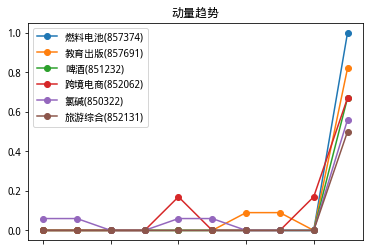

In [5]:
result.T.plot(kind='line', marker='o', title='动量趋势')

## 按3日涨幅排序，统计涨幅超过8%的个股，列出板块动量前6名+最强个股（最多6个）

In [4]:
result, top_security = get_result(3, security_date_close_money_dict)
result.iloc[:, -1:].join(top_security)

,11-16,2020-11-16 前排个股名称
其他稀有小金属(850544),4.92,"[西部材料(20.31%), 华友钴业(18.71%), 贵研铂业(11.21%), 三祥新材(10.01%), 洛阳钼业(10.00%), 宝钛股份(9.26%), 寒锐钴业(9.07%)]"
涤纶(850341),3.27,"[桐昆股份(16.41%), 新凤鸣(12.76%), 恒逸石化(12.01%), 江南高纤(11.61%), 恒天海龙(11.58%), 海利得(10.83%)]"
其他化学制品(850339),2.53,"[新安股份(21.12%), 硅宝科技(18.20%), 青松股份(15.45%), 德方纳米(15.05%), 中核钛白(12.16%), 建新股份(11.03%), 奥克股份(10.72%)]"
铝(850551),2.33,"[和胜股份(13.58%), 怡球资源(12.64%), 神火股份(12.48%), 新疆众和(12.16%), 豪美新材(9.85%), 焦作万方(8.93%), 云铝股份(8.40%)]"
氨纶(850345),2.00,"[泰和新材(9.65%), 华峰氨纶(9.58%)]"
其他采掘(850231),1.60,"[河钢资源(18.13%), 攀钢钒钛(17.29%), 安宁股份(13.07%), 西藏矿业(11.21%)]"


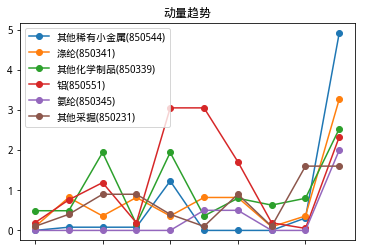

In [5]:
result.T.plot(kind='line', marker='o', title='动量趋势')

## 按5日涨幅排序，统计涨幅超过10%的个股，列出板块动量前6名+最强个股（最多6个）

In [6]:
result, top_security = get_result(5, security_date_close_money_dict)
result.iloc[:, -1:].join(top_security)

,11-16,2020-11-16 前排个股名称
涤纶(850341),3.27,"[桐昆股份(27.25%), 新凤鸣(18.42%), 恒逸石化(15.16%), 海利得(12.24%), 东方盛虹(11.33%), 恒天海龙(10.80%)]"
氨纶(850345),2.00,"[华峰氨纶(18.35%), 泰和新材(10.22%)]"
其他采掘(850231),1.60,"[河钢资源(32.57%), 攀钢钒钛(20.10%), 安宁股份(16.43%), 西藏矿业(14.71%)]"
白酒(851231),1.56,"[金徽酒(27.97%), 金种子酒(22.50%), 老白干酒(18.21%), 山西汾酒(16.02%), 迎驾贡酒(14.26%)]"
其他化学制品(850339),1.43,"[德方纳米(30.98%), 龙蟒佰利(23.38%), 新安股份(20.45%), 硅宝科技(17.00%), 中核钛白(15.88%), 金禾实业(14.05%), 安纳达(12.62%)]"
铝(850551),1.19,"[云铝股份(20.98%), 神火股份(20.68%), 豪美新材(11.21%), 新疆众和(10.59%), 宏创控股(10.51%)]"


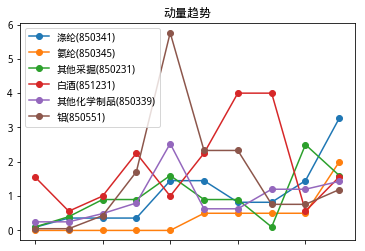

In [7]:
result.T.plot(kind='line', marker='o', title='动量趋势')

## 按10日涨幅排序，统计涨幅超过15%的个股，列出板块动量前6名+最强个股（最多6个）

In [8]:
result, top_security = get_result(10, security_date_close_money_dict)
result.iloc[:, -1:].join(top_security)

,11-16,2020-11-16 前排个股名称
铝(850551),6.86,"[云铝股份(38.50%), 和胜股份(36.49%), 神火股份(35.36%), 焦作万方(29.27%), 新疆众和(26.56%), 怡球资源(22.67%), 南山铝业(21.52%)]"
涤纶(850341),5.82,"[东方盛虹(42.15%), 桐昆股份(30.80%), 恒力石化(26.98%), 荣盛石化(24.37%), 苏州龙杰(22.93%), 恒逸石化(21.39%), 海利得(20.88%)]"
铅锌(850553),5.79,"[西部矿业(31.99%), 华钰矿业(26.44%), 株冶集团(24.73%), 宏达股份(18.66%), 西藏珠峰(17.41%), 锌业股份(17.22%), 中色股份(16.63%)]"
其他稀有小金属(850544),3.77,"[西部材料(30.38%), 盛屯矿业(28.47%), 华友钴业(24.52%), 贵研铂业(16.25%), 云南锗业(15.81%), 锡业股份(15.65%), 寒锐钴业(15.10%)]"
其他采掘(850231),3.60,"[河钢资源(59.21%), 西藏矿业(45.72%), 攀钢钒钛(25.50%), 安宁股份(21.83%), 金岭矿业(20.62%), 海南矿业(15.87%)]"
黄酒(851236),3.00,"[金枫酒业(27.37%), 会稽山(18.83%), 古越龙山(17.70%)]"


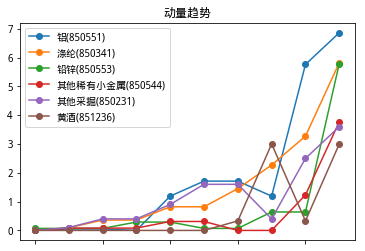

In [9]:
result.T.plot(kind='line', marker='o', title='动量趋势')

## 按20日涨幅排序，统计涨幅超过20%的个股，列出板块动量前6名+最强个股（最多6个）

In [10]:
result, top_security = get_result(20, security_date_close_money_dict)
result.iloc[:, -1:].join(top_security)

,11-16,2020-11-16 前排个股名称
白酒(851231),4.00,"[金徽酒(141.30%), 老白干酒(59.00%), 迎驾贡酒(52.62%), 金种子酒(43.75%), 泸州老窖(31.98%), 山西汾酒(31.20%), 伊力特(26.56%)]"
涤纶(850341),3.27,"[东方盛虹(42.81%), 桐昆股份(23.59%), 苏州龙杰(23.05%), 恒力石化(22.98%), 荣盛石化(22.36%), 恒逸石化(22.21%)]"
其他采掘(850231),2.50,"[河钢资源(63.82%), 西藏矿业(30.87%), 攀钢钒钛(21.84%), 安宁股份(21.12%), 金石资源(20.14%)]"
玻璃制造(850611),2.00,"[旗滨集团(50.17%), 南玻A(34.54%), 金晶科技(31.86%), 亚玛顿(23.10%)]"
冰箱(851111),1.80,"[澳柯玛(34.41%), 海信家电(29.38%), 海尔智家(29.18%)]"
乘用车(850911),1.78,"[比亚迪(32.75%), 上汽集团(26.40%), 广汽集团(24.38%), 长安汽车(23.88%)]"


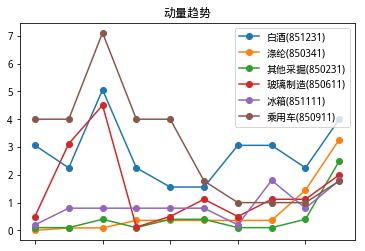

In [11]:
result.T.plot(kind='line', marker='o', title='动量趋势')